In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine

# 1.

In [2]:
# dataset_wine = load_wine()
# wine_df = pd.DataFrame(dataset_wine.data, columns=dataset_wine.feature_names)
# wine_df['class'] = dataset_wine.target
# wine_df.head()

In [3]:
dataset_wine = pd.read_csv('winequality-white.csv', sep=';')
wine_df = dataset_wine
print(wine_df['quality'].unique())
wine_df.head()

[6 5 7 8 4 3 9]


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [5]:
X = wine_df.drop('quality', axis=1)
y = wine_df['quality']
# X = wine_df.drop('class', axis=1)
# y = wine_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model = CatBoostClassifier(loss_function='MultiClass', iterations=350, random_seed=42)
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)
# model = SVC(kernel='linear', probability=True, random_state=42)
# model.fit(X_train, y_train)

Learning rate set to 0.165712
0:	learn: 1.7246014	test: 1.7304988	best: 1.7304988 (0)	total: 141ms	remaining: 49.3s
1:	learn: 1.5725113	test: 1.5907820	best: 1.5907820 (1)	total: 155ms	remaining: 27s
2:	learn: 1.4713832	test: 1.4977412	best: 1.4977412 (2)	total: 172ms	remaining: 19.9s
3:	learn: 1.3875615	test: 1.4205213	best: 1.4205213 (3)	total: 186ms	remaining: 16.1s
4:	learn: 1.3205524	test: 1.3572458	best: 1.3572458 (4)	total: 203ms	remaining: 14s
5:	learn: 1.2716936	test: 1.3112575	best: 1.3112575 (5)	total: 218ms	remaining: 12.5s
6:	learn: 1.2327056	test: 1.2735490	best: 1.2735490 (6)	total: 234ms	remaining: 11.4s
7:	learn: 1.2002870	test: 1.2446134	best: 1.2446134 (7)	total: 249ms	remaining: 10.7s
8:	learn: 1.1712196	test: 1.2185771	best: 1.2185771 (8)	total: 265ms	remaining: 10s
9:	learn: 1.1491847	test: 1.2005598	best: 1.2005598 (9)	total: 281ms	remaining: 9.56s
10:	learn: 1.1278284	test: 1.1832000	best: 1.1832000 (10)	total: 294ms	remaining: 9.07s
11:	learn: 1.1090920	test: 1

# 2.

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score

In [7]:
y_predict = model.predict(X_test)

cm = confusion_matrix(y_test, y_predict)

# Accuracy
accuracy = accuracy_score(y_test, y_predict)

#Precision
precision = precision_score(y_test, y_predict, average='weighted')

#Recall
recall = recall_score(y_test, y_predict, average='weighted')

#Specificity
specificity_per_class = []

for i in range(len(cm)):
    true_negatives = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
    false_positives = np.sum(np.delete(cm[:, i], i))
    specificity = true_negatives / (true_negatives + false_positives)
    specificity_per_class.append(specificity)

print(f'Specificity per class: {specificity_per_class}\nAverage Specificity: {np.mean(specificity_per_class):.3f}\n')
print(f'Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}\n')
print(f'Conf matrix:\n{cm}')

Specificity per class: [1.0, 0.9947201689545935, 0.865021770682148, 0.6203703703703703, 0.9402985074626866, 0.9978835978835979, 1.0]
Average Specificity: 0.917

Accuracy: 0.640, Precision: 0.642, Recall: 0.640

Conf matrix:
[[  0   1   1   2   0   0   0]
 [  0   8  19   6   0   0   0]
 [  0   3 178 104   6   0   0]
 [  0   1  68 338  33   0   0]
 [  0   0   4  85  85   2   0]
 [  0   0   1   8   8  18   0]
 [  0   0   0   0   1   0   0]]


c:\Users\Ivan K\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 3, 4. 

## ROC-AUG on test

In [8]:
from sklearn.preprocessing import label_binarize
y_bin = label_binarize(y_test, classes=[3, 4, 5, 6, 7, 8, 9])
# y_bin = label_binarize(y_test, classes=[0, 1, 2])
y_bin

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

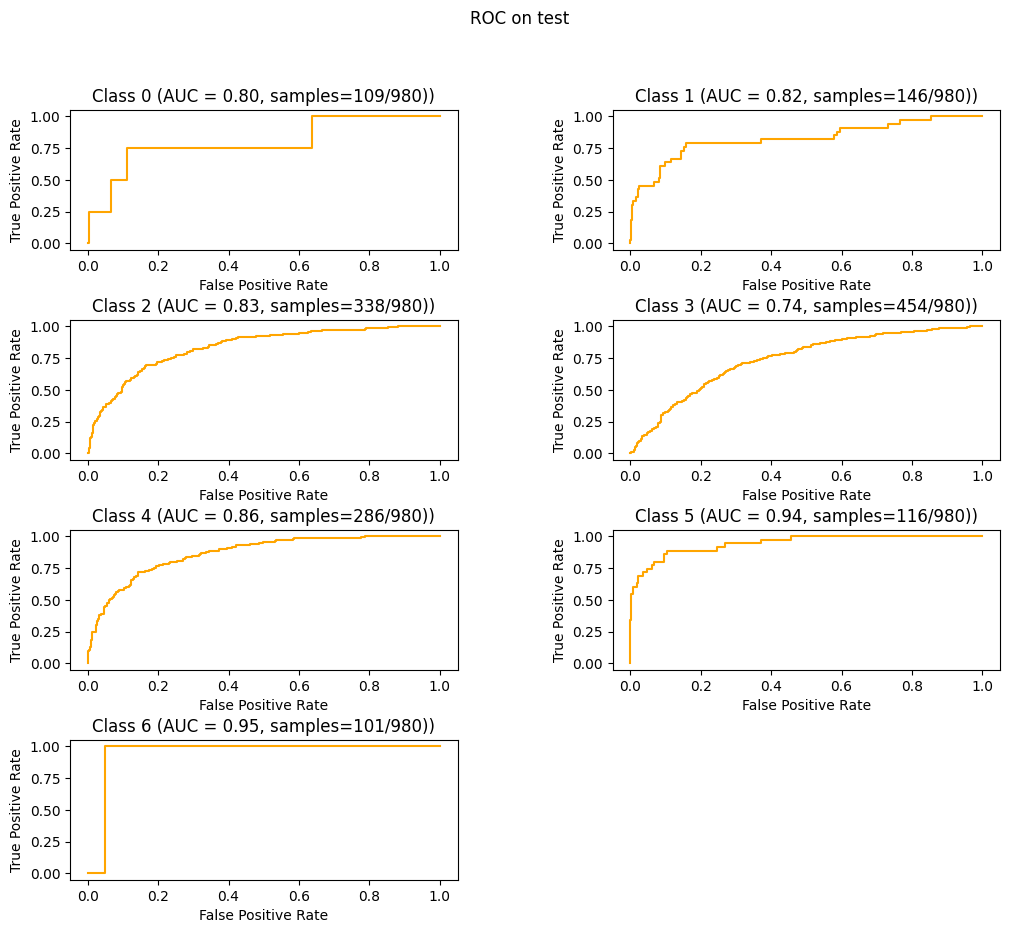

In [9]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_predict_probs = model.predict_proba(X_test)

for i in range(y_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_predict_probs[:, i])
    roc_auc[i] = roc_auc_score(y_bin[:, i], y_predict_probs[:, i])

plt.figure(figsize=(12, 10))
plt.suptitle('ROC on test')
plt.subplots_adjust(hspace=0.5, wspace=0.4)
for i in range(y_bin.shape[1]):
    #print(y_bin.shape[1] // 2 + 1, y_bin.shape[1] % 2 + 1, i + 1)
    plt.subplot(y_bin.shape[1] // 2 + 1, y_bin.shape[1] % 2 + 1, i + 1)
    plt.plot(fpr[i], tpr[i], 'orange')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Class {i} (AUC = {roc_auc[i]:.2f}, samples={len(tpr[i])}/{len(X_test)}))')

## ROC-AUG on train

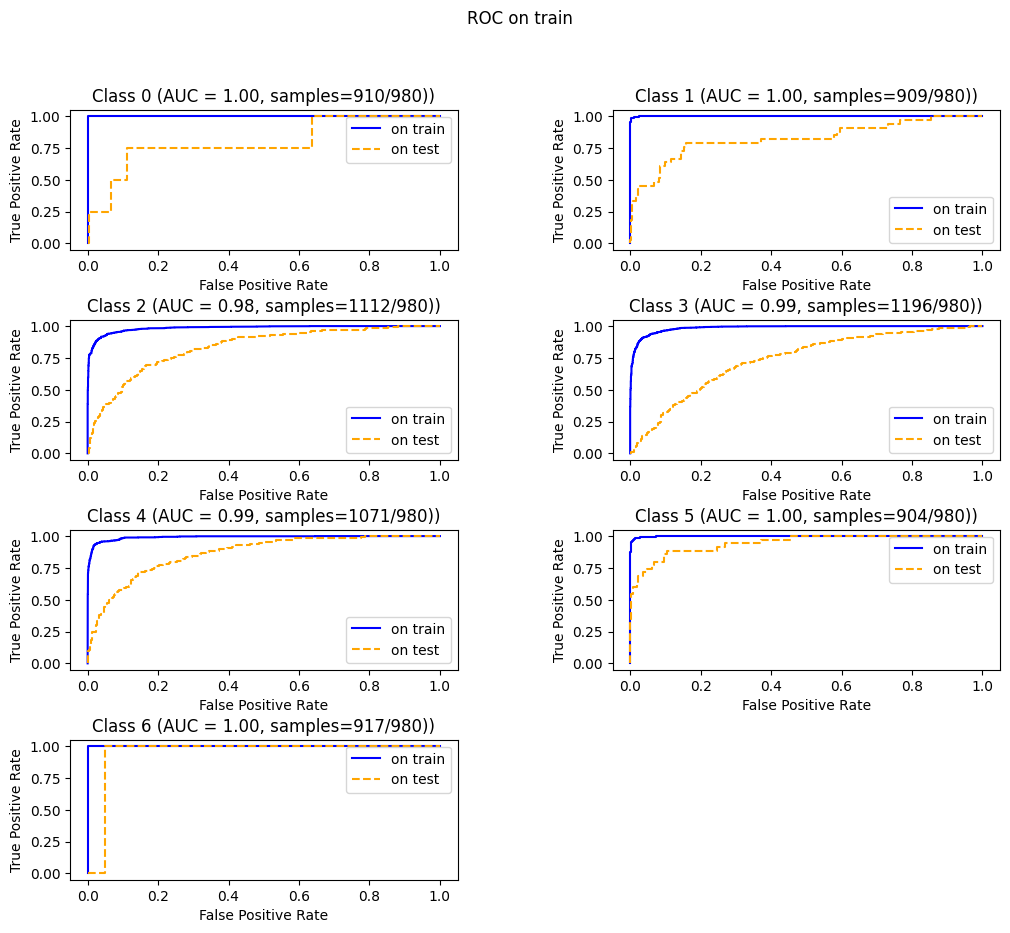

In [10]:
y_bin_train = label_binarize(y_train, classes=[3, 4, 5, 6, 7, 8, 9])
# y_bin = label_binarize(y_train, classes=[0, 1, 2])

fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()
y_predict_probs_train = model.predict_proba(X_train)

for i in range(y_bin_train.shape[1]):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_bin_train[:, i], y_predict_probs_train[:, i])
    roc_auc_train[i] = roc_auc_score(y_bin_train[:, i], y_predict_probs_train[:, i])

plt.figure(figsize=(12, 10))
plt.suptitle('ROC on train')
plt.subplots_adjust(hspace=0.5, wspace=0.4)
for i in range(y_bin_train.shape[1]):
    #print(y_bin.shape[1] // 2 + 1, y_bin.shape[1] % 2 + 1, i + 1)
    plt.subplot(y_bin_train.shape[1] // 2 + 1, y_bin_train.shape[1] % 2 + 1, i + 1)
    plt.plot(fpr_train[i], tpr_train[i], linestyle='-', color='blue', label='on train')
    plt.plot(fpr[i], tpr[i], linestyle='--', color='orange', label='on test')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Class {i} (AUC = {roc_auc_train[i]:.2f}, samples={len(tpr_train[i])}/{len(X_test)}))')
    plt.legend()

## ROC-AUG on cross-val

In [11]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict

Learning rate set to 0.205983
0:	learn: 1.6768410	total: 15.1ms	remaining: 5.26s
1:	learn: 1.5039558	total: 28.6ms	remaining: 4.98s
2:	learn: 1.4048427	total: 44.1ms	remaining: 5.09s
3:	learn: 1.3232042	total: 57.9ms	remaining: 5.01s
4:	learn: 1.2643336	total: 71.6ms	remaining: 4.94s
5:	learn: 1.2187830	total: 86.3ms	remaining: 4.95s
6:	learn: 1.1807102	total: 99.2ms	remaining: 4.86s
7:	learn: 1.1471178	total: 111ms	remaining: 4.75s
8:	learn: 1.1220265	total: 124ms	remaining: 4.69s
9:	learn: 1.1014071	total: 137ms	remaining: 4.64s
10:	learn: 1.0838148	total: 148ms	remaining: 4.56s
11:	learn: 1.0683782	total: 159ms	remaining: 4.49s
12:	learn: 1.0545009	total: 173ms	remaining: 4.47s
13:	learn: 1.0402143	total: 185ms	remaining: 4.44s
14:	learn: 1.0282774	total: 198ms	remaining: 4.43s
15:	learn: 1.0180116	total: 211ms	remaining: 4.41s
16:	learn: 1.0077634	total: 223ms	remaining: 4.38s
17:	learn: 0.9986886	total: 238ms	remaining: 4.39s
18:	learn: 0.9926455	total: 253ms	remaining: 4.4s
19:	l

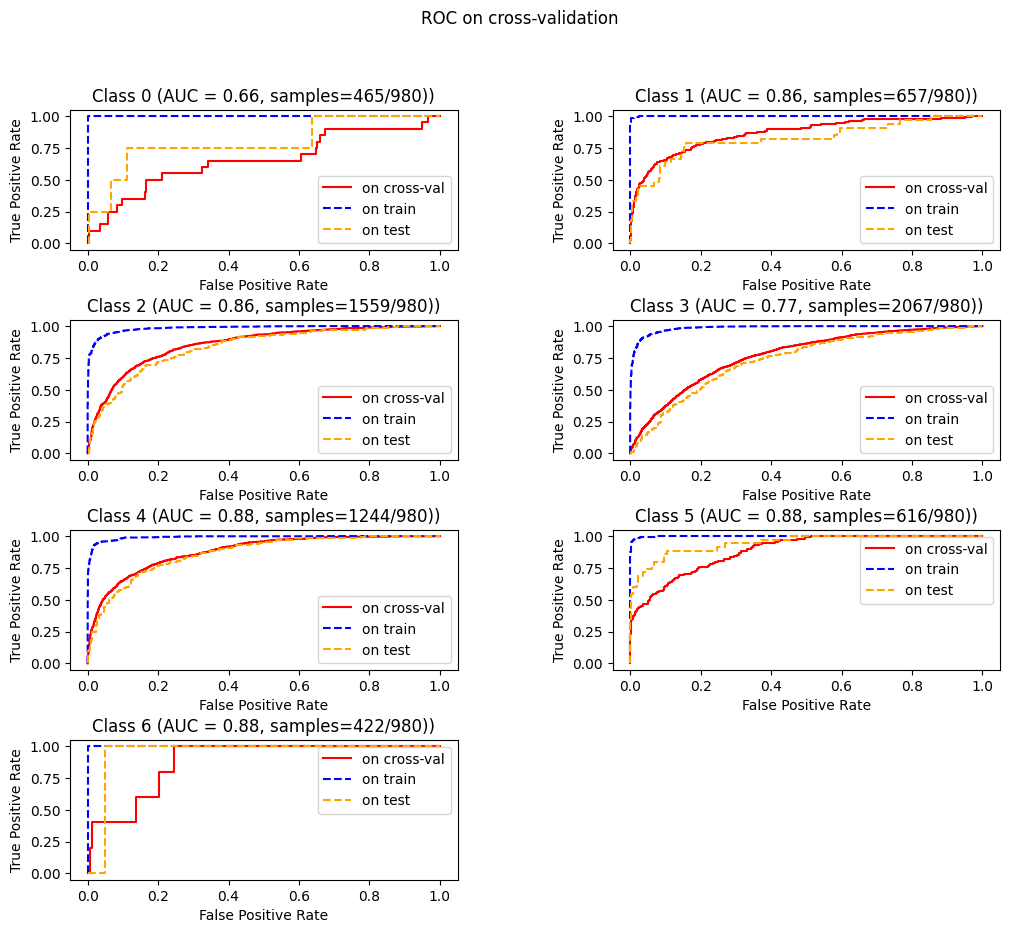

In [12]:
X = wine_df.drop('quality', axis=1)
y = wine_df['quality']

y_bin_cross_val = label_binarize(y, classes=[3, 4, 5, 6, 7, 8, 9])

model_cross_val = CatBoostClassifier(loss_function='MultiClass', iterations=350, random_seed=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_predict_probs_cross_val = cross_val_predict(model_cross_val, X, y, cv=cv, method='predict_proba')

fpr_cross_val = dict()
tpr_cross_val = dict()
roc_auc_cross_val = dict()

for i in range(y_bin.shape[1]):
    fpr_cross_val[i], tpr_cross_val[i], _ = roc_curve(y_bin_cross_val[:, i], y_predict_probs_cross_val[:, i])
    roc_auc_cross_val[i] = roc_auc_score(y_bin_cross_val[:, i], y_predict_probs_cross_val[:, i])

plt.figure(figsize=(12, 10))
plt.suptitle('ROC on cross-validation')
plt.subplots_adjust(hspace=0.5, wspace=0.4)

for i in range(y_bin_cross_val.shape[1]):
    plt.subplot(y_bin_cross_val.shape[1] // 2 + 1, y_bin_cross_val.shape[1] % 2 + 1, i + 1)
    plt.plot(fpr_cross_val[i], tpr_cross_val[i], linestyle='-', color='red', label='on cross-val')
    plt.plot(fpr_train[i], tpr_train[i], linestyle='--', color='blue', label='on train')
    plt.plot(fpr[i], tpr[i], linestyle='--', color='orange', label='on test')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Class {i} (AUC = {roc_auc_cross_val[i]:.2f}, samples={len(tpr_cross_val[i])}/{len(X_test)}))')
    plt.legend()


По кросс валидации:  
confidence interval  
Разброс от min до max по выборкам

## Precision-Recall curve

In [13]:
from sklearn.metrics import precision_recall_curve, auc

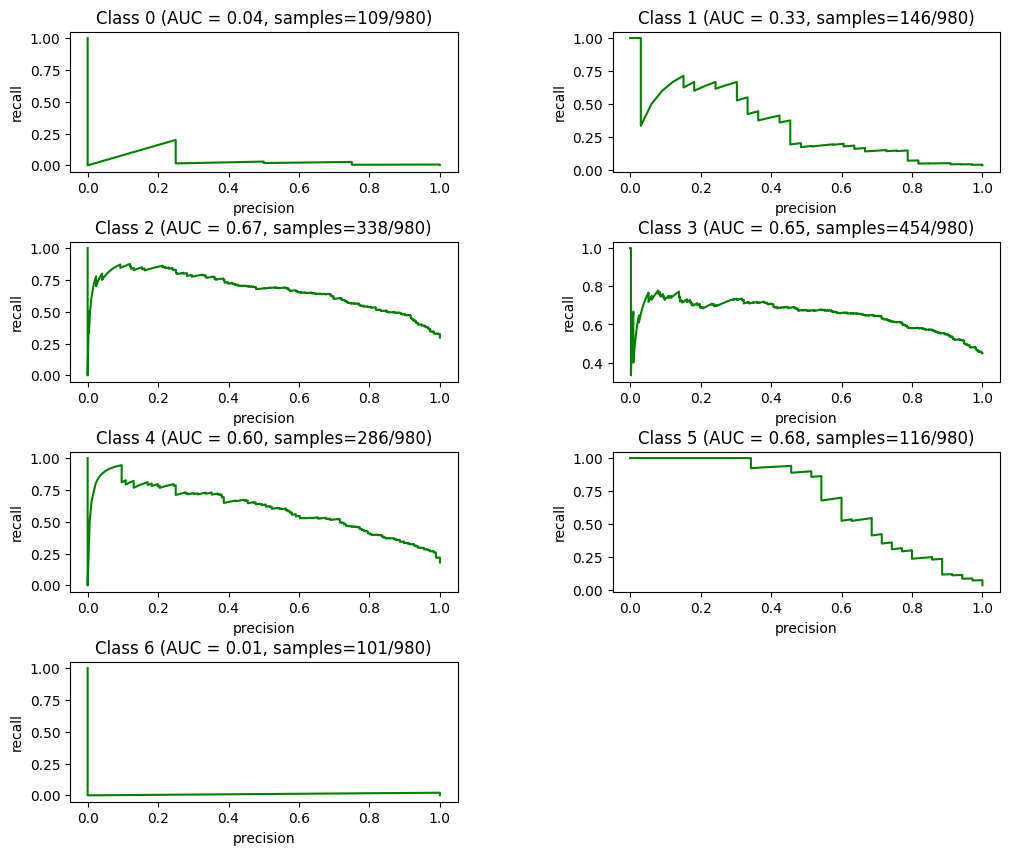

In [18]:
fpr2 = dict()
tpr2 = dict()
pr_auc = dict()
y_predict_probs = model.predict_proba(X_test)

for i in range(y_bin.shape[1]):
    fpr2[i], tpr2[i], _ = precision_recall_curve(y_bin[:, i], y_predict_probs[:, i])
    pr_auc[i] = auc(tpr2[i], fpr2[i])

plt.figure(figsize=(12, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.4)
for i in range(y_bin.shape[1]):
    #print(y_bin.shape[1] // 2 + 1, y_bin.shape[1] % 2 + 1, i + 1)
    plt.subplot(y_bin.shape[1] // 2 + 1, y_bin.shape[1] % 2 + 1, i + 1)
    plt.plot(tpr2[i], fpr2[i], 'green')
    plt.ylabel('precision')
    plt.xlabel('recall')
    plt.title(f'Class {i} (AUC = {pr_auc[i]:.2f}, samples={len(tpr[i])}/{len(X_test)})')

# 5.

In [15]:
from sklearn.metrics import log_loss
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [16]:
X = wine_df.drop('quality', axis=1)
y = wine_df['quality']

# 2. Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_bin5 = label_binarize(y_test, classes=[3, 4, 5, 6, 7, 8, 9])

# 3. Обучение моделей
# AdaBoost
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train)

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

c:\Users\Ivan K\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


GradientBoostingClassifier(random_state=42)

c:\Users\Ivan K\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



class 0
AdaBoost - AUC: 0.54, Log Loss: 0.16, Precision: 0.00, Recall: 0.00
Gradient Boosting - AUC: 0.53, Log Loss: 0.09, Precision: 0.00, Recall: 0.00

class 1
AdaBoost - AUC: 0.51, Log Loss: 0.24, Precision: 0.00, Recall: 0.00
Gradient Boosting - AUC: 0.80, Log Loss: 0.12, Precision: 0.46, Recall: 0.36

class 2
AdaBoost - AUC: 0.67, Log Loss: 0.66, Precision: 0.41, Recall: 0.88
Gradient Boosting - AUC: 0.80, Log Loss: 0.50, Precision: 0.63, Recall: 0.53

class 3
AdaBoost - AUC: 0.48, Log Loss: 0.90, Precision: 0.47, Recall: 0.38
Gradient Boosting - AUC: 0.68, Log Loss: 0.70, Precision: 0.57, Recall: 0.75

class 4
AdaBoost - AUC: 0.70, Log Loss: 0.47, Precision: 0.00, Recall: 0.00
Gradient Boosting - AUC: 0.83, Log Loss: 0.36, Precision: 0.56, Recall: 0.34

class 5
AdaBoost - AUC: 0.69, Log Loss: 0.24, Precision: 0.00, Recall: 0.00
Gradient Boosting - AUC: 0.91, Log Loss: 0.10, Precision: 0.69, Recall: 0.26

class 6
AdaBoost - AUC: 0.93, Log Loss: 0.02, Precision: 0.00, Recall: 0.00

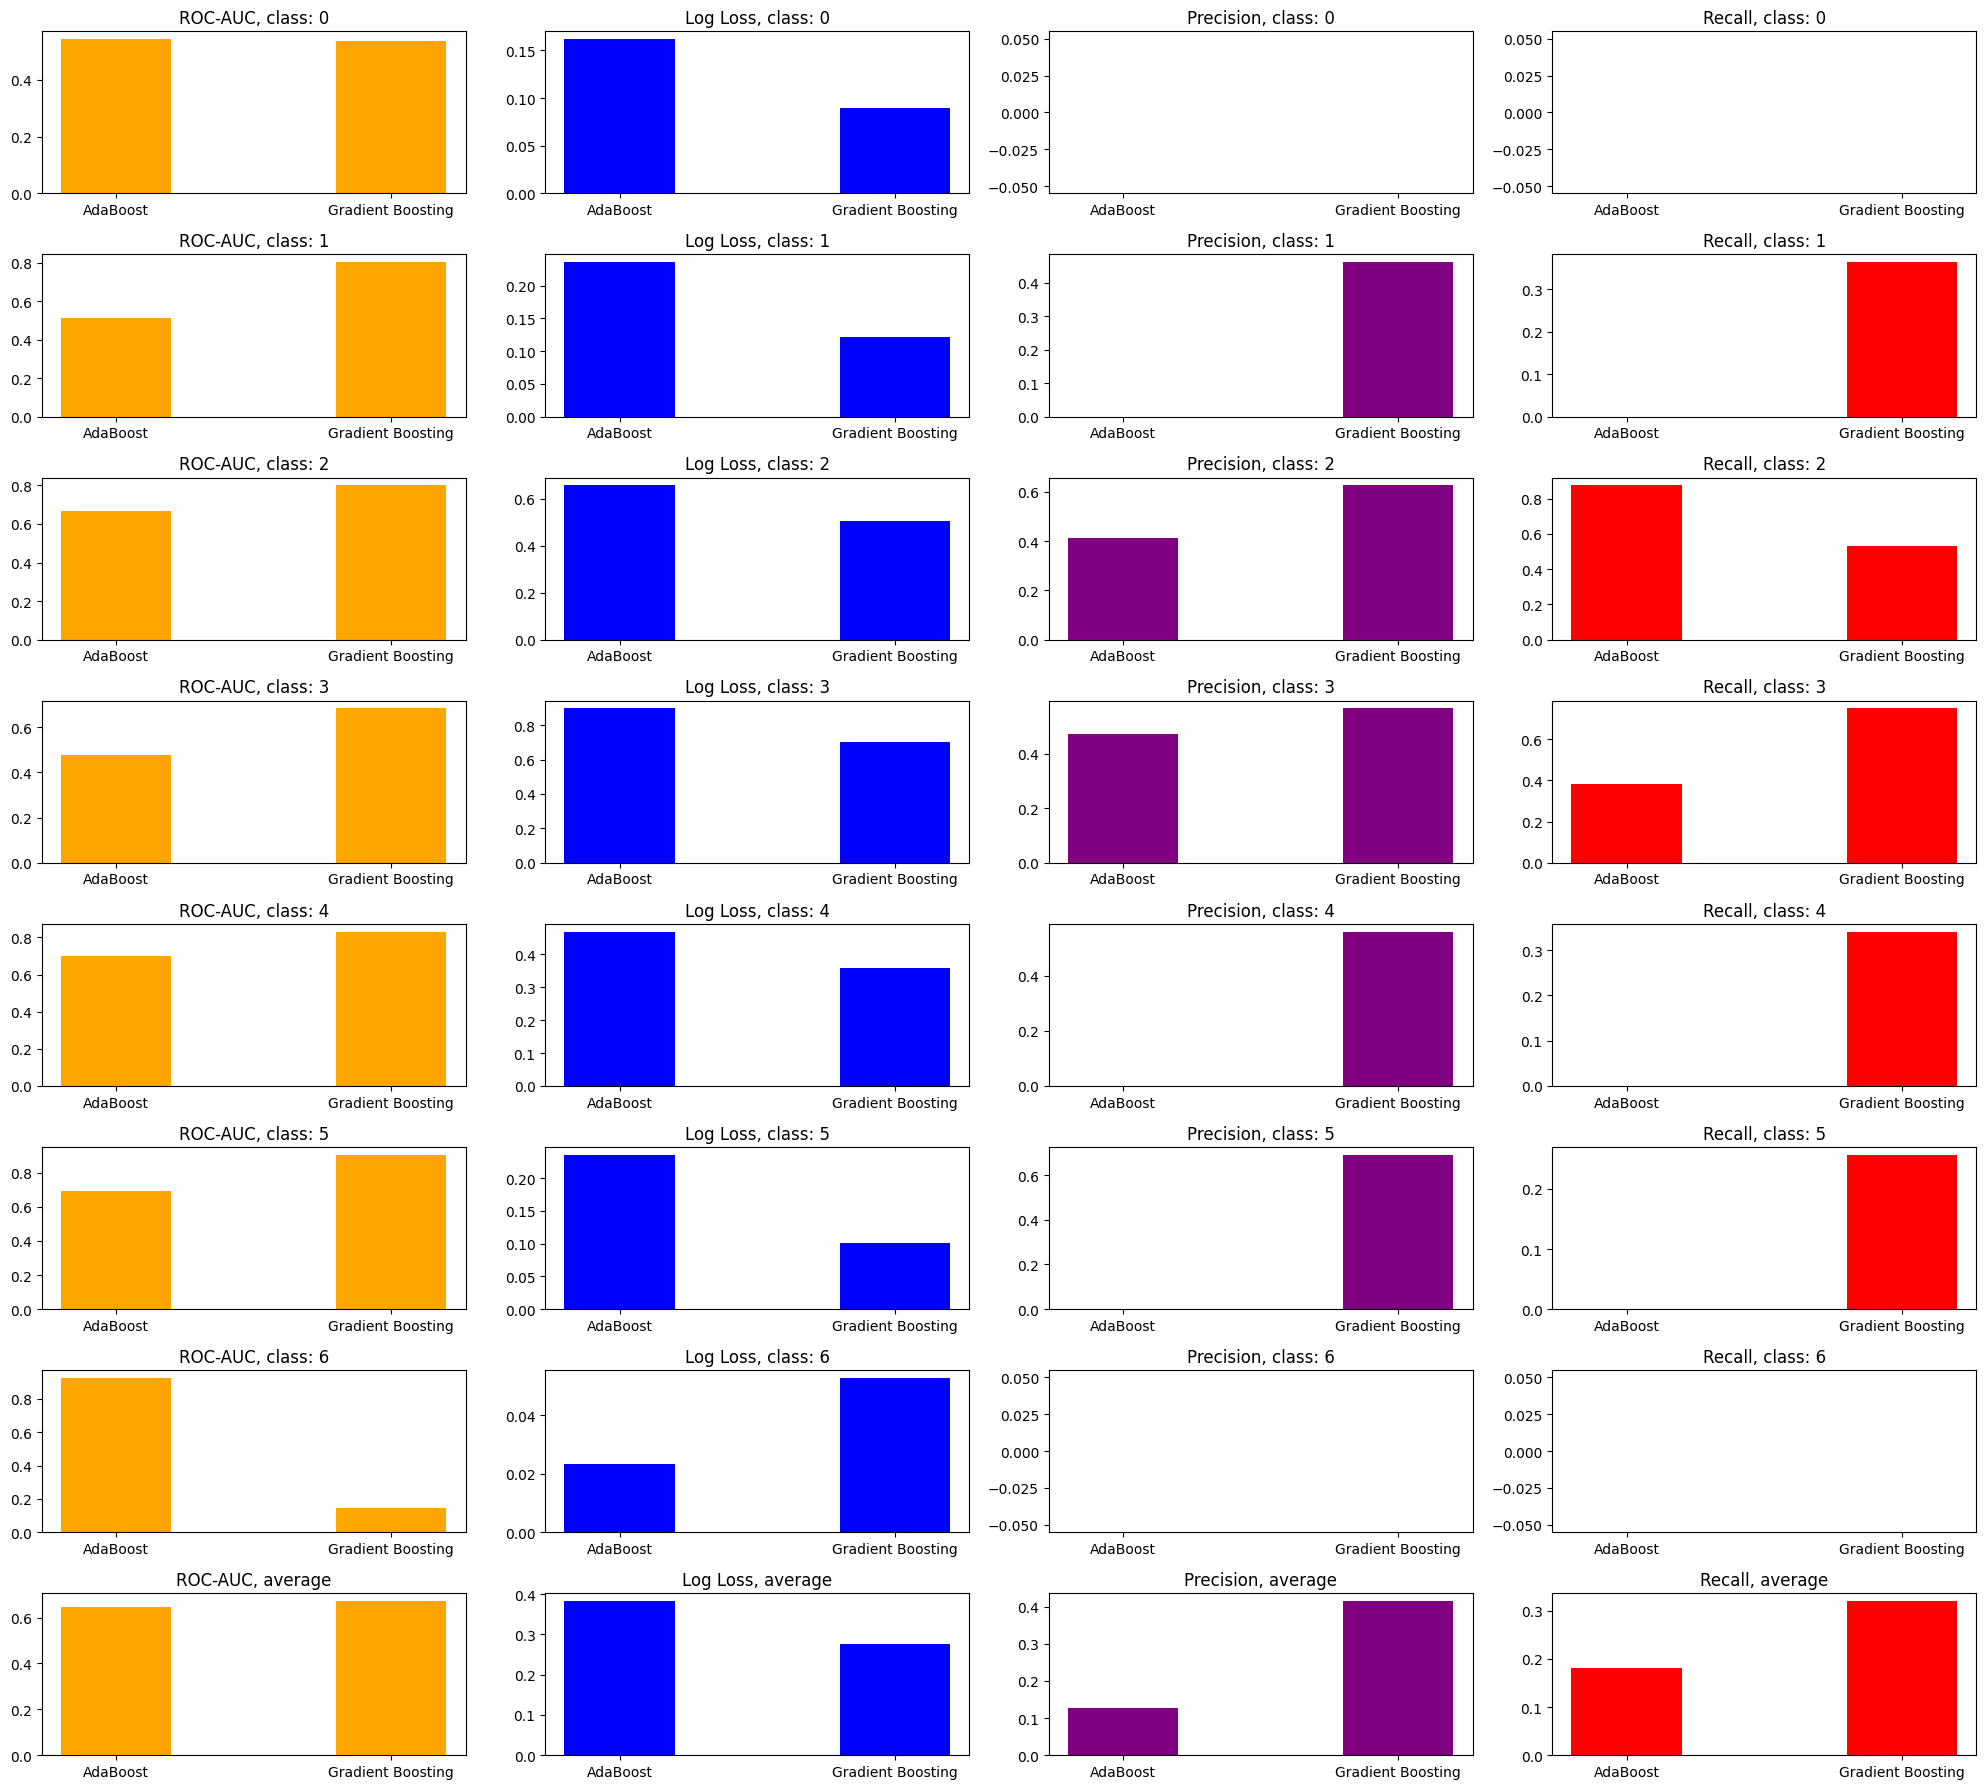

In [17]:
y_pred_ada = ada_model.predict(X_test)
y_pred_proba_ada = ada_model.predict_proba(X_test)

y_pred_gb = gb_model.predict(X_test)
y_pred_proba_gb = gb_model.predict_proba(X_test)

accuracy_ada = accuracy_score(y_test, y_pred_ada)
accuracy_gb = accuracy_score(y_test, y_pred_gb)

precision_ada = precision_score(y_test, y_pred_ada, average=None)
precision_gb = precision_score(y_test, y_pred_gb, average=None)

recall_ada = recall_score(y_test, y_pred_ada, average=None)
recall_gb = recall_score(y_test, y_pred_gb, average=None)

avg_auc_ada, avg_auc_gb = 0, 0
avg_log_loss_ada, avg_log_loss_gb = 0, 0
avg_precision_ada, avg_precision_gb = 0, 0
avg_recall_ada, avg_recall_gb = 0, 0

num_of_metrics = 4
fig, ax = plt.subplots(y_bin.shape[1] + 1, num_of_metrics, figsize=(20, 18))
for i in range(y_bin.shape[1]):
    roc_auc_ada = roc_auc_score(y_bin5[:, i], y_pred_proba_ada[:, i]) 
    roc_auc_gb = roc_auc_score(y_bin5[:, i], y_pred_proba_gb[:, i])

    log_loss_ada = log_loss(y_bin5[:,i], y_pred_proba_ada[:,i])
    log_loss_gb = log_loss(y_bin5[:,i], y_pred_proba_gb[:,i])
    #log_loss_ada = log_loss(y_test, y_pred_proba_ada)
    #log_loss_gb = log_loss(y_test, y_pred_proba_gb)

    avg_auc_ada += roc_auc_ada
    avg_auc_gb += roc_auc_gb
    avg_log_loss_ada += log_loss_ada
    avg_log_loss_gb += log_loss_gb
    avg_precision_ada += precision_ada[i]
    avg_precision_gb += precision_gb[i]
    avg_recall_ada += recall_ada[i]
    avg_recall_gb += recall_gb[i]

    print(f"\nclass {i}")
    #print(f"AdaBoost - AUC: {roc_auc_ada:.2f}, Log Loss: {log_loss_ada:.2f}")
    #print(f"Gradient Boosting - AUC: {roc_auc_gb:.2f}, Log Loss: {log_loss_gb:.2f}")
    print(f"AdaBoost - AUC: {roc_auc_ada:.2f}, Log Loss: {log_loss_ada:.2f}, Precision: {precision_ada[i]:.2f}, Recall: {recall_ada[i]:.2f}")
    print(f"Gradient Boosting - AUC: {roc_auc_gb:.2f}, Log Loss: {log_loss_gb:.2f}, Precision: {precision_gb[i]:.2f}, Recall: {recall_gb[i]:.2f}")

    # Визуализация результатов
    labels = ['AdaBoost', 'Gradient Boosting']
    auc_scores = [roc_auc_ada, roc_auc_gb]
    log_losses = [log_loss_ada, log_loss_gb]
    #accuracies = [accuracy_ada, accuracy_gb]
    precisions = [precision_ada[i], precision_gb[i]]
    recalls = [recall_ada[i], recall_gb[i]]

    x = np.arange(len(labels))

    titles = [f'ROC-AUC, class: {i}', f'Log Loss, class: {i}', f'Precision, class: {i}', f'Recall, class: {i}']
    ax[i][0].bar(x, auc_scores, 0.4, label=f'AUC, class: {i}', color='orange')
    ax[i][1].bar(x, log_losses, 0.4, label=f'Log Loss, class: {i}', color='blue')
    ax[i][2].bar(x, precisions, 0.4, label=f'Precision, class: {i}', color='purple')
    ax[i][3].bar(x, recalls, 0.4, label=f'Recall, class: {i}', color='red')

    for (j, a) in enumerate(ax[i]):
        a.set_title(titles[j])
        a.set_xticks(x)
        a.set_xticklabels(labels)
        #a.legend()

avg_auc_ada /= y_bin.shape[1]
avg_auc_gb /= y_bin.shape[1]
avg_log_loss_ada /= y_bin.shape[1]
avg_log_loss_gb /= y_bin.shape[1]
avg_precision_ada /= y_bin.shape[1]
avg_precision_gb /= y_bin.shape[1]
avg_recall_ada /= y_bin.shape[1]
avg_recall_gb /= y_bin.shape[1]

print(f"\nAverage")
#print(f"AdaBoost - AUC: {roc_auc_ada:.2f}, Log Loss: {log_loss_ada:.2f}")
#print(f"Gradient Boosting - AUC: {roc_auc_gb:.2f}, Log Loss: {log_loss_gb:.2f}")
print(f"AdaBoost - AUC: {avg_auc_ada:.2f}, Log Loss: {avg_log_loss_ada:.2f}, Precision: {avg_precision_ada:.2f}, Recall: {avg_recall_ada:.2f}")
print(f"Gradient Boosting - AUC: {avg_auc_gb:.2f}, Log Loss: {avg_log_loss_gb:.2f}, Precision: {avg_precision_gb:.2f}, Recall: {avg_recall_gb:.2f}")

titles = [f'ROC-AUC, average', f'Log Loss, average', f'Precision, average', f'Recall, average']
ax[y_bin.shape[1]][0].bar(x, [avg_auc_ada, avg_auc_gb], 0.4, label=f'AUC, average', color='orange')
ax[y_bin.shape[1]][1].bar(x, [avg_log_loss_ada, avg_log_loss_gb], 0.4, label=f'Log Loss, average', color='blue')
ax[y_bin.shape[1]][2].bar(x, [avg_precision_ada, avg_precision_gb], 0.4, label=f'Precision, average', color='purple')
ax[y_bin.shape[1]][3].bar(x, [avg_recall_ada, avg_recall_gb], 0.4, label=f'Recall, average', color='red')
for (j, a) in enumerate(ax[y_bin.shape[1]]):
    a.set_title(titles[j])
    a.set_xticks(x)
    a.set_xticklabels(labels)

plt.tight_layout()
plt.show()